## Import libraries

In [11]:
import math
import json
import folium
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from numpy import cos, sin, arcsin, sqrt
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
%matplotlib inline
plt.figure(figsize=(20,5))

PALETTE_DEG = ["FF"]
PALETTE = ["#FFC30D", "#EF404B"]
PALETTE_ALT = ["#40EFE4", "#EF404B"]

R = 6371
KMS_AROUND = 3.20
WINDOW_TIME = 3.12

<Figure size 1440x360 with 0 Axes>

In [3]:
df = pd.read_pickle("../data/shippify_icd_task_new.pkl", compression='gzip')

## Utils functions

In [4]:
def set_labels(title=None, x_label=None, y_label=None, fontsize=14, legend=None):
  if title is not None:
    plt.title(title, fontsize=fontsize)
  if x_label is not None:
    plt.xlabel(x_label, fontsize=fontsize)
  if y_label is not None:
    plt.ylabel(y_label, fontsize=fontsize)
  if legend is not None:
    legend['object'].set_title(legend['title'])
    for t, l in zip(legend['object'].texts, legend['texts']): t.set_text(l)

def with_hue(plot, feature, categories, hue_categories, diff=False):
  a = [p.get_height() for p in plot.patches]
  patch = [p for p in plot.patches]
  differences = {'class': [], 'value': []}
  for i in range(categories):
    total = a[i] + a[i+categories]
    difference = []
    for j in range(hue_categories):
      value = round(100 * a[(j*categories + i)]/total, 2)
      percentage = '{:.1f}%'.format(value)
      x = patch[(j*categories + i)].get_x() + patch[(j*categories + i)].get_width() / 2 - 0.15
      y = patch[(j*categories + i)].get_y() + patch[(j*categories + i)].get_height() 
      plt.annotate(percentage, (x, y), size = 12)
      if diff:
        difference.append(value)
    if diff:
      diff_value = abs(round(difference[0]-difference[1], 2))
      differences['class'].append(feature[i])
      differences['value'].append(diff_value)
      print('{0:16s}: |{1:>5} - {2:>5}| = {3:>5}'.format(feature[i], difference[0], difference[1], diff_value))
    #print(f'{feature[i]}: {difference[0]} - {difference[1]} = {abs(round(difference[0]-difference[1], 2))}')
  plt.show()
  if diff:
    return pd.DataFrame.from_dict(differences)
  
class display(object):
  """Display HTML representation of multiple objects"""
  template = """<div style="float: left; padding: 10px;">
  <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
  </div>"""
  def __init__(self, *args):
    self.args = args

  def _repr_html_(self):
    return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)

  def __repr__(self):
    return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

## Enmanuel Magallanes

## Question: Is the total size of packages a factor affecting the timeliness of deliveries?

In [5]:
#dict of size
size_dict = { 1: 'X Small', 2: 'Small', 3: 'Medium', 4: 'Large', 5: 'X Large' }

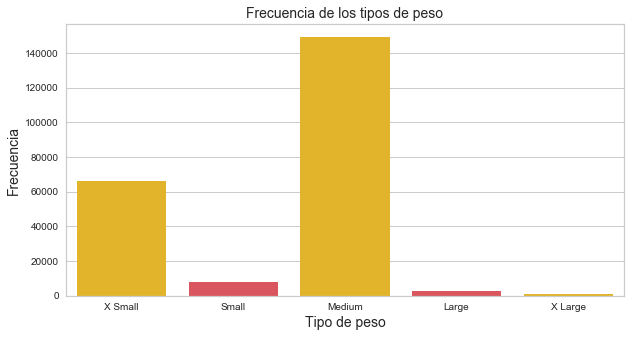

In [6]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='total_size', order=size_dict.values(), palette=PALETTE)
set_labels('Frecuencia de los tipos de peso', 'Tipo de peso', 'Frecuencia')

X Small         : |45.86 - 54.14| =  8.28
Small           : |49.41 - 50.59| =  1.18
Medium          : |23.47 - 76.53| = 53.06
Large           : |13.29 - 86.71| = 73.42
X Large         : |31.04 - 68.96| = 37.92


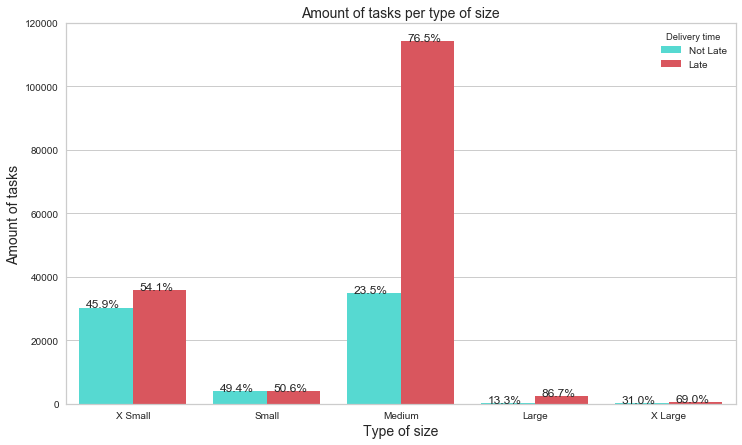

In [7]:
gsl = df[['id', 'total_size', 'is_late']].groupby(['total_size', 'is_late'])['id'].count().reset_index()
plt.figure(figsize=(12,7))
plt.tight_layout()
f = sns.barplot(data=gsl, x='total_size', y='id', hue='is_late', order=size_dict.values(), palette=PALETTE_ALT)

set_labels(
  'Amount of tasks per type of size', 'Type of size', 'Amount of tasks', 
  legend={'object': f.get_legend(), 'title': 'Delivery time', 'texts': ['Not Late', 'Late']
})
diff_size = with_hue(f, list(size_dict.values()), 5, 2, diff=True)

In the graph we can see that there are more deliveries with size X Small and Medium than the others. However, what is important here is to analyze the percentage of tasks delivered on time and those that are not. There are no significant differences between Small and Small X-size tasks. In contrast, Medium, Large and X Large tasks have a significant difference in the percentage of on-time deliveries. This indicates that the size of deliverables affects on-time delivery when their size is equal to or larger than Medium.

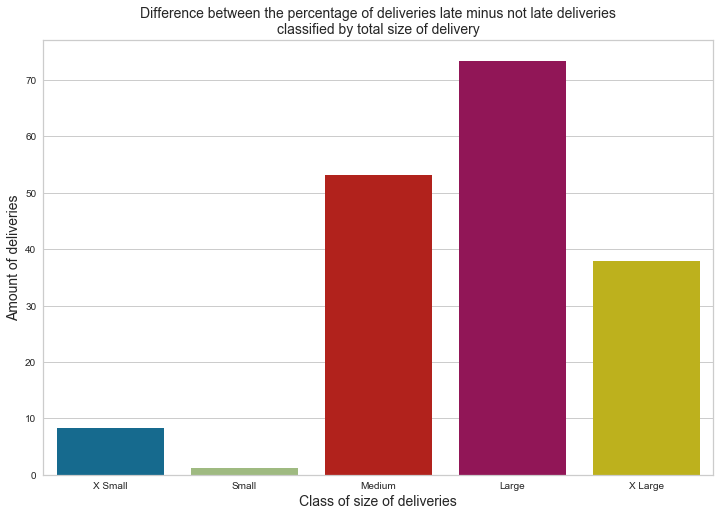

In [9]:
plt.figure(figsize=(12,8))
plt.tight_layout()
sns.barplot(data=diff_size, x='class', y='value')
set_labels(
  title='Difference between the percentage of deliveries late minus not late deliveries\nclassified by total size of delivery',
  x_label='Class of size of deliveries', y_label='Amount of deliveries'
)

## Question 2: Are tasks with fewer neighboring deliveries* taking longer to reach their delivery point?
\* We define neighboring deliveries as all those deliveries that are less than or equal to X KM away from the same and their delivery date is within T hours of the same.

In [12]:
# We will group deliveries by route ID, to get the average distance and time from the first delivery to the last delivery. 
# With these values we will obtain distance and time ranges to find the route density.
def haversine_distance(x, y):
  lon1, lat1, lon2, lat2 = map(math.radians, [x[0], x[1], y[0], y[1]])
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
  c = 2 * math.asin(sqrt(a))
  return R * c

def generate_combinations(points):
  combinations = []
  for i in range(len(points)):
    for j in range(i+1, len(points)):
      combinations.append([points[i], points[j]])
  return combinations

def calculate_time(group):
  min_dt = group['delivery_dt'].min()
  max_dt = group['delivery_dt'].max()
  return (max_dt - min_dt).total_seconds() / 3600

def calculate_distance(group):
  group = group.set_index('delivery_dt')
  group = group.sort_values('delivery_dt')
  center = (group['long'].mean(), group['lat'].mean())
  return np.array(group.apply(lambda r: haversine_distance((r.long, r.lat), center), axis=1)).mean()

gr_hours = df.groupby('route_id').apply(calculate_time)
gr_distance = df.groupby('route_id').apply(calculate_distance)

Mean time from first delivery to the last delivery: 3.12 hours


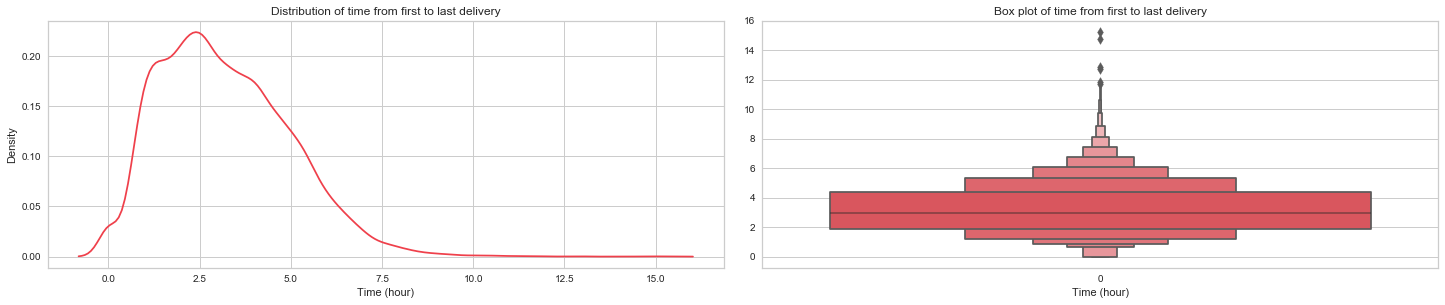

In [13]:
fig, ax =plt.subplots(1,2, figsize=(20,4))
fig.tight_layout()

ax[0].set_title('Distribution of time from first to last delivery')
ax[0].set_xlabel('Time (hour)')
sns.kdeplot(data=gr_distance, ax=ax[0], color=PALETTE[1])

ax[1].set_title('Box plot of time from first to last delivery')
ax[1].set_xlabel('Time (hour)')
sns.boxenplot(data=gr_distance, ax=ax[1], color=PALETTE[1])

print('Mean time from first delivery to the last delivery: {0:.2f} hours'.format(gr_hours.mean()))

Mean distance first delivery to the last delivery: 3.20 km


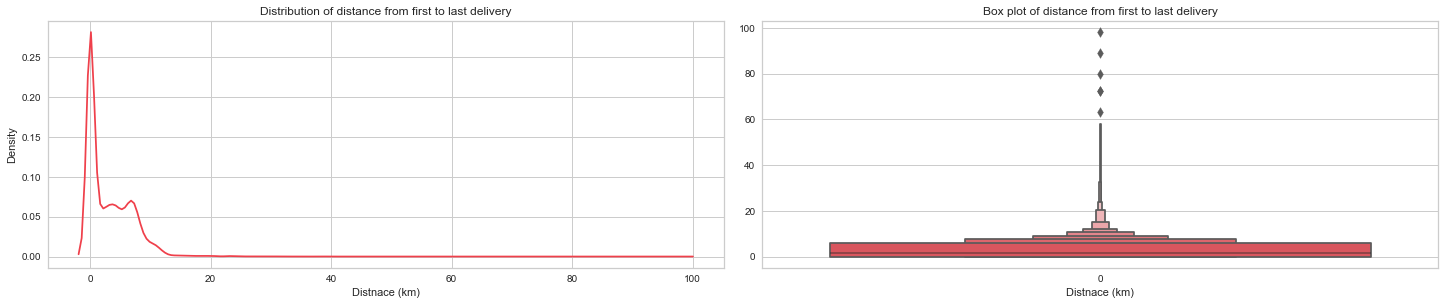

In [14]:
fig, ax =plt.subplots(1,2, figsize=(20,4))
fig.tight_layout()

ax[0].set_title('Distribution of distance from first to last delivery')
ax[0].set_xlabel('Distnace (km)')
sns.kdeplot(data=gr_hours, ax=ax[0], color=PALETTE[1])

ax[1].set_title('Box plot of distance from first to last delivery')
ax[1].set_xlabel('Distnace (km)')
sns.boxenplot(data=gr_hours, ax=ax[1], color=PALETTE[1])
print('Mean distance first delivery to the last delivery: {0:.2f} km'.format(gr_distance.mean()))

As we can see the scheduled time from the first delivery to the last delivery, on average, is 3.12 hours and the distance, on average, is 3.20 km. These values will be our time window and radius to use to determine the number of deliveries that exist around one

In [15]:
df['class_neighboring'] = pd.cut(
  df['task_around'], 
  include_lowest=True,
  bins=[x for x in range(0, 800, 100)]
)
#df_filtered['class_neighboring'] = df_filtered['class_neighboring'].astype('str')

In [17]:
# Remoiving outlayers using the z-score
z_scores = stats.zscore(df['task_around'])
abs_z_scores = np.abs(z_scores)
filtered_entries = abs_z_scores < 3
df_filtered = df[ filtered_entries ]
task_around_filtered = df[ filtered_entries ]['task_around']

Mean neighboring deliveries: 167.37 deliveries
STD neighboring deliveries: 139.15


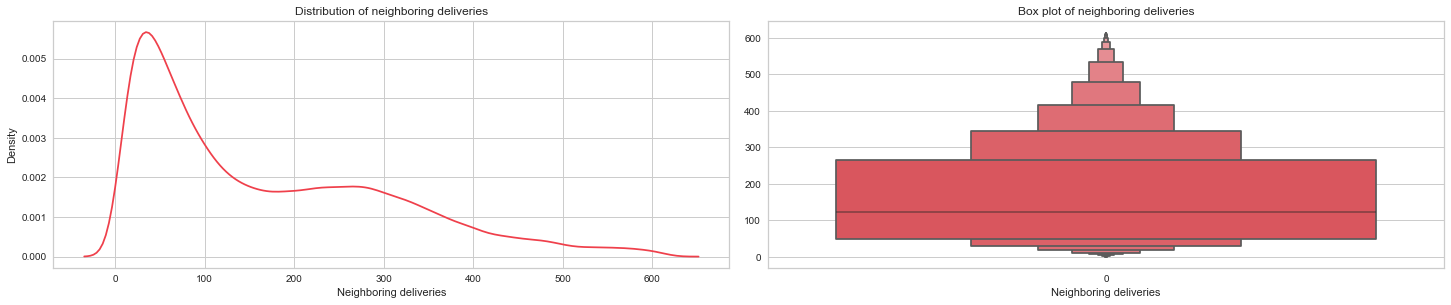

In [19]:
fig, ax =plt.subplots(1,2, figsize=(20,4))
fig.tight_layout()

ax[0].set_title('Distribution of neighboring deliveries')
ax[0].set_xlabel('Neighboring deliveries')
sns.kdeplot(data=df_filtered['task_around'], ax=ax[0], color=PALETTE[1])

ax[1].set_title('Box plot of neighboring deliveries')
ax[1].set_xlabel('Neighboring deliveries')
sns.boxenplot(data=task_around_filtered, ax=ax[1], color=PALETTE[1])

print('Mean neighboring deliveries: {0:.2f} deliveries'.format(task_around_filtered.mean()))
print('STD neighboring deliveries: {0:.2f}'.format(task_around_filtered.std()))

(-0.001, 100.0] : |41.61 - 58.39| = 16.78
(100.0, 200.0]  : |28.14 - 71.86| = 43.72
(200.0, 300.0]  : |24.59 - 75.41| = 50.82
(300.0, 400.0]  : |18.32 - 81.68| = 63.36
(400.0, 500.0]  : |11.01 - 88.99| = 77.98
(500.0, 600.0]  : | 5.26 - 94.74| = 89.48
(600.0, 700.0]  : |  5.0 -  95.0| =  90.0


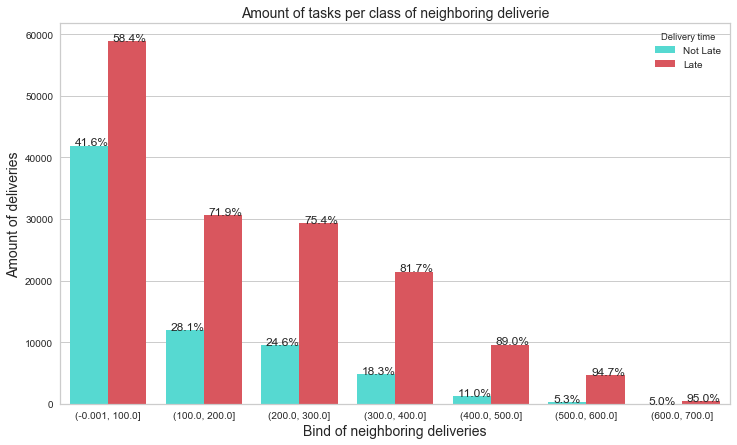

In [26]:
gnl = df_filtered[['id', 'class_neighboring', 'is_late']].groupby(['class_neighboring', 'is_late'])['id'].count().reset_index()
plt.figure(figsize=(12,7))
plt.tight_layout()
f = sns.barplot(data=gnl, x='class_neighboring', y='id', hue='is_late', palette=PALETTE_ALT)

set_labels(
  'Amount of tasks per class of neighboring deliverie', 'Bind of neighboring deliveries', 'Amount of deliveries', 
  legend={'object': f.get_legend(), 'title': 'Delivery time', 'texts': ['Not Late', 'Late']
})
classes_list = list(map(lambda item: str(item), df_filtered['class_neighboring'].sort_values().unique()))
diff_list = with_hue(f, classes_list, 7, 2, diff=True)

In the plot we can see that as the number of neighboring deliveries increases, the percentage of late deliveries also increases. This tells us that the higher the concentration or density of deliveries around you, the more likely it is that you will be late in reaching the final customer

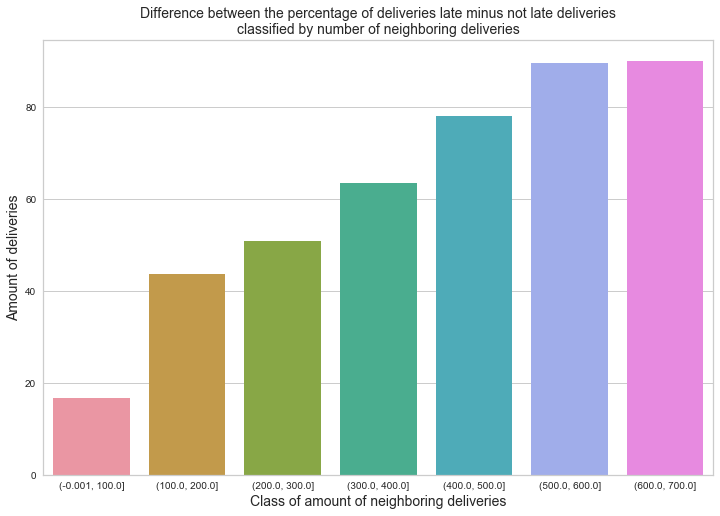

In [27]:
plt.figure(figsize=(12,8))
plt.tight_layout()
sns.barplot(data=diff_list, x='class', y='value')
set_labels(
  title='Difference between the percentage of deliveries late minus not late deliveries\nclassified by number of neighboring deliveries',
  x_label='Class of amount of neighboring deliveries', y_label='Amount of deliveries'
)

## Ploting location of task with low and hight neighboring deliveries 

In [ ]:
diff = df['delivery'] - df['delivery_effective']
df['delay_delivery'] = diff.apply(lambda x: abs(int(x.total_seconds()))) / 3600

In [31]:
def get_color(tasks):
  """Get color for task"""
  if tasks == 0:
    return 'black'
  elif 0 <= tasks < 300:
    return 'blue'
  elif 300 <= tasks < 1000:
    return 'red'

def add_marker(row, map_stg):
  folium.Marker(
    location=[row['lat'], row['long']],
    popup=row['id'],
    icon=folium.Icon(color=get_color(row['task_around']))
  ).add_to(map_stg)

stg_map = folium.Map(location=[-33.469477, -70.643929], zoom_start=12)
a = df \
[['lat', 'long', 'id', 'class_neighboring', 'task_around']].sample(100).apply(
  lambda r: add_marker(r, stg_map), axis=1
)
#[ (df['task_around']>=400) & (df['task_around']<800) ] \
#stg_map

## Clustering (KMeans)

In [34]:
RAMDOM_SEED = 2048
convert_std = True
features = [
  'delivery_type', 'total_size', 'distance', 
  'delivery_dt', 'lat', 'long', 'task_around',

  'pickup_effective_dt', 'city', 'total_task', 'cost'
]
stad_dist = ['lat', 'long']
stad_dt = ['delivery_dt', 'pickup_effective_dt']
stad_cols = ['total_size', 'distance','task_around', 'cost']

In [36]:
dff = df.copy()

dff.delivery_dt = dff.delivery_dt.view('i8')
dff.delivery_effective = dff.delivery_effective.view('i8')
dff.pickup_effective_dt = dff.pickup_effective_dt.view('i8')

dff.total_size = dff.total_size.astype('category').cat.codes
dff.delivery_type = dff.delivery_type.astype('category').cat.codes

if convert_std:
  scaler = MinMaxScaler(feature_range=(0, 10))
  dff[stad_cols] = scaler.fit_transform(dff[stad_cols])

  scaler_dist = MinMaxScaler(feature_range=(0, 10))
  dff[stad_dist] = scaler_dist.fit_transform(dff[stad_dist])

  scaler_dt = MinMaxScaler(feature_range=(0, 1e4))
  dff[stad_dt] = scaler_dt.fit_transform(dff[stad_dt])

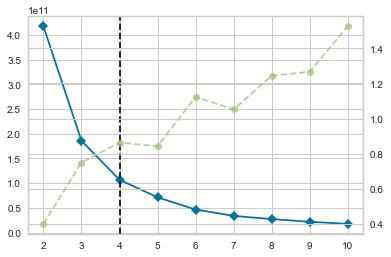

In [41]:
dff_features = dff[features]
model = KMeans(init='k-means++', random_state=RAMDOM_SEED)
try:
  visualizer = KElbowVisualizer(model, n_clusters=(2,10), timings=True)
  visualizer.fit(dff_features)
  visualizer
except:
  pass

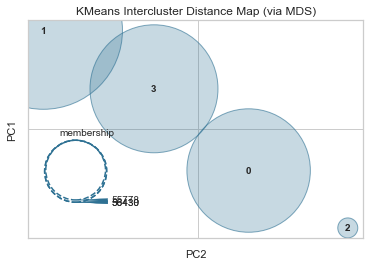

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [42]:
model = KMeans(n_clusters=visualizer.elbow_value_, init='k-means++', random_state=RAMDOM_SEED)
model.fit(dff_features)
y_means = model.predict(dff_features)

interDistance = InterclusterDistance(model, random_state=RAMDOM_SEED)
interDistance.fit(dff_features)
interDistance.show()

In [43]:
df['cluster'] = model.labels_

[(-33.7, -33.1), (-70.4, -71.0)]

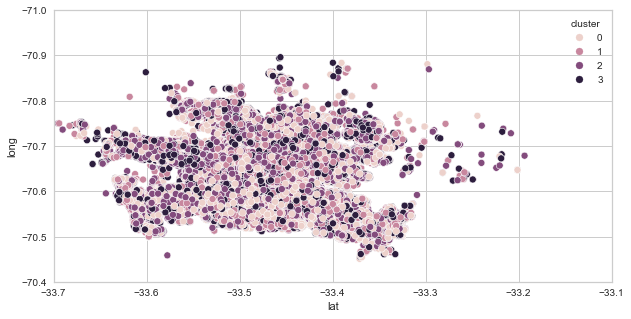

In [63]:
plt.figure(figsize=(10,5))
plt.tight_layout()
sns.scatterplot(data=df, x='lat', y='long', hue='cluster').set(xlim=(-33.70, -33.1), ylim=(-70.4, -71))

In [65]:
print(df[ df['cluster'] == 0 ][features].delivery_dt.mean())
df[ df['cluster'] == 0 ][features].describe()

2020-07-29 04:11:00.583258624+00:00


,distance,lat,long,task_around,city,total_task,cost
count,55778.000000,55778.000000,55778.000000,55778.000000,55778.0,55778.0,55778.000000
mean,18.745636,-33.452279,-70.609637,153.162609,3.0,226828.0,1765.487251
std,13.785408,0.060162,0.065502,119.118497,0.0,0.0,794.758401
min,0.000000,-33.675701,-70.893600,1.000000,3.0,226828.0,0.000000
25%,11.800000,-33.488800,-70.647202,50.000000,3.0,226828.0,1500.000000
50%,18.600000,-33.445202,-70.594902,115.000000,3.0,226828.0,1511.329956
75%,24.700001,-33.410400,-70.565697,250.000000,3.0,226828.0,2000.000000
max,1625.199951,-33.201302,-70.450798,585.000000,3.0,226828.0,23094.400391


In [67]:
print(df[ df['cluster'] == 1 ][features].delivery_dt.mean())
df[ df['cluster'] == 1 ][features].describe()

2020-06-11 19:59:46.045041408+00:00


,distance,lat,long,task_around,city,total_task,cost
count,62942.000000,62942.000000,62942.000000,62942.000000,62942.0,62942.0,62942.000000
mean,18.560540,-33.446514,-70.601959,212.940183,3.0,226828.0,1720.992397
std,8.639622,0.056732,0.064168,185.476240,0.0,0.0,839.646583
min,0.000000,-33.694099,-70.872902,1.000000,3.0,226828.0,0.000000
25%,11.800000,-33.477501,-70.628899,57.000000,3.0,226828.0,1500.000000
50%,18.900000,-33.438900,-70.587997,156.000000,3.0,226828.0,1500.000000
75%,24.600000,-33.407101,-70.560699,324.000000,3.0,226828.0,1967.270020
max,365.899994,-33.218300,-70.464699,970.000000,3.0,226828.0,33652.800781


In [68]:
print(df[ df['cluster'] == 2 ][features].delivery_dt.mean())
df[ df['cluster'] == 2 ][features].describe()

2020-08-19 14:13:44.076880128+00:00


,distance,lat,long,task_around,city,total_task,cost
count,51678.000000,51678.000000,51678.000000,51678.000000,51678.0,51678.0,51678.000000
mean,16.706790,-33.455340,-70.608988,143.667789,3.0,226828.0,1732.364329
std,17.898310,0.060537,0.111681,117.338330,0.0,0.0,849.365166
min,0.000000,-34.749699,-70.869102,1.000000,3.0,226828.0,0.000000
25%,10.600000,-33.492298,-70.647598,46.000000,3.0,226828.0,1375.150024
50%,16.299999,-33.448101,-70.596298,102.000000,3.0,226828.0,1500.000000
75%,22.500000,-33.413399,-70.566803,230.000000,3.0,226828.0,1840.000000
max,2839.000000,-33.193699,-58.473202,599.000000,3.0,226828.0,22848.000000


In [69]:
print(df[ df['cluster'] == 3 ][features].delivery_dt.mean())
df[ df['cluster'] == 3 ][features].describe()

2020-07-04 22:55:19.132039424+00:00


,distance,lat,long,task_around,city,total_task,cost
count,56430.000000,56430.000000,56430.000000,56430.000000,56430.0,56430.0,56430.000000
mean,18.538540,-33.448992,-70.607476,172.046128,3.0,226828.0,1794.455954
std,17.635859,0.058227,0.066525,141.429540,0.0,0.0,891.601132
min,0.000000,-33.679798,-70.895798,1.000000,3.0,226828.0,0.000000
25%,11.400000,-33.482300,-70.641800,50.000000,3.0,226828.0,1500.000000
50%,18.500000,-33.441502,-70.591499,128.000000,3.0,226828.0,1500.000000
75%,24.600000,-33.408100,-70.564003,274.000000,3.0,226828.0,2000.000000
max,3372.699951,-33.201302,-70.455399,812.000000,3.0,226828.0,35000.000000


## Josue Cobos

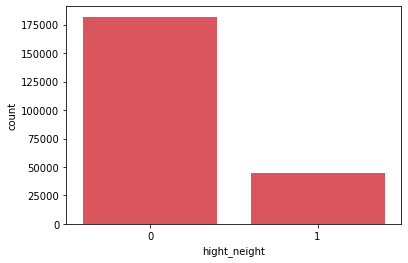

In [163]:
g = sns.countplot(data=df_t, x='hight_neight', color=PALETTE_ALT[1])
g.set_xticks([0,1])

In [ ]:
#Question: Are those deliveries that are further from the economic center of Belo Horizonte those with the longest delivery delay?

In [ ]:
#calculate distance between 2 lat long points
def calculateDistance(point, anotherPoint):
    lat1, lon1 = point
    lat2, lon2 = anotherPoint 
    R = 6373.0
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance #kilometers

In [ ]:
#For this question we will assume Barreiro in the most important regional administration of Belo Horizonte
BARREIROPOINT = (-19.977, -44.0145)
def getDistanceFromA(row):
  #print(row)
  return calculateDistance(BARREIROPOINT, (row['lat'], row['long']))
  #return row #distance

In [ ]:
df['dst_to_barreiro'] = df[['lat', 'long']].apply(getDistanceFromA, axis=1)

In [ ]:
plt.figure(figsize=(15,7))
subdf = df[['dst_to_barreiro','delay_delivery']]
f2 = sns.scatterplot(x=subdf['dst_to_barreiro'], y=subdf['delay_delivery'])
#with_hue(f, df.class_weight, 8, 2)

In [ ]:
subdf.corr()

In [ ]:
#Answer: Due to the non-existent correlation between the delay of shipments (delay_delivery) and distance to Barreiro (dst_to_barreiro), we can conclude that no matter how far your order is, it does not necessarily mean that it has a longer delay time.